Dataset used :Bitcoin_Historical_Price 
Source: Kaggle

Imports

In [60]:
import os
from scipy.stats import boxcox
import os

import numpy as np
import pandas as pd
from fbprophet import Prophet
from pyramid.arima import auto_arima
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as  pyplot
import warnings
warnings.filterwarnings('ignore')

Custom Error function and Preprocessing

In [61]:
#Symmetric mean absolute percentage error

def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = math.fabs(y_pred[i])
        c = a + b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= 100.0 / y_true.shape[0]
    return out[0]


def time_series_preprocessing(file_path):


    data_frame = pd.read_csv(path, sep=",|;", header=0, names=['ds', 'y'], engine="python")

    data_frame = data_frame.fillna(method='ffill').fillna(method='bfill')

    data_frame['ds'] = pd.to_datetime(data_frame['ds'], dayfirst=True, errors='ignore')
    data_frame = data_frame.sort_values(by='ds')
    return data_frame 


Loading the data

In [62]:
path = '/home/aditya/Bitcoin_Historical_Price.csv'
data_frame = time_series_preprocessing(path)

Time series Decomposition into trend , seasonality and residual(remainder)

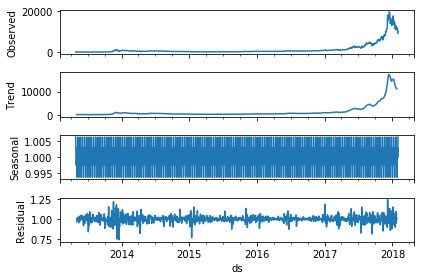

In [63]:

dd = data_frame.set_index('ds')
result = seasonal_decompose(dd,model='multiplicative',freq=12)
result.plot()
pyplot.show()

Power Transformation for dealing with outlier in data

In [64]:
data_frame['y'] = np.log(data_frame['y'])

Cross validation on 1month data of jan 2018

In [65]:
series_train, series_test = train_test_split(data_frame, test_size=0.0178058587, shuffle=False)


Indexing and No of steps to forecast ahead

In [66]:
series_test = series_test.set_index(['ds'])
steps = len(series_test)

loading original dataframe to cross validate results

In [67]:
final_frame = pd.read_csv(path, sep=",|;", header=0, names=['Date', 'Actual'], engine="python")
final = final_frame[1710:]
test = final.set_index(['Date'])
final_frame

,Date,Actual
0,27-04-2013,134.21
1,28-04-2013,144.54
2,29-04-2013,139.00
3,30-04-2013,116.99
4,01-05-2013,105.21
5,02-05-2013,97.75
6,03-05-2013,112.50
7,04-05-2013,115.91
8,05-05-2013,112.30
9,06-05-2013,111.50


MODEL Seasonal ARIMA

In [68]:
################################################################################################
series_arima = series_train.set_index(['ds'])
# Model training
arima_model = auto_arima(series_arima, start_p=1, max_p=5, start_q=1, max_q=5,
                         start_P=1, max_P=3, start_Q=1, max_Q=3,
                         max_d=2, max_D=1, trend='c',
                         m=12, max_order=None,
                         stationary=False, seasonal=True, stepwise=True, trace=True,
                         error_action='ignore', suppress_warnings=True, maxiter=50,out_of_sample_size=30)
arima_forecast = arima_model.predict(n_periods=steps)
arima_forecast = np.exp(arima_forecast)
arima_loss = smape_fast(np.asarray(test), arima_forecast)
final['ARIMA'+' '+ 'SMAPE='+str(arima_loss)] = arima_forecast
print("SMAPE ARIMA = ", arima_loss)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=-5793.734, BIC=-5761.178, Fit time=1.964 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-5801.660, BIC=-5790.808, Fit time=0.274 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-5797.710, BIC=-5776.006, Fit time=1.173 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-5797.708, BIC=-5776.004, Fit time=4.321 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-5799.710, BIC=-5783.432, Fit time=0.849 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=-5799.708, BIC=-5783.430, Fit time=0.902 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=-5797.674, BIC=-5775.970, Fit time=1.147 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-5799.661, BIC=-5783.383, Fit time=0.156 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=-5799.661, BIC=-5783.383, Fit time=0.302 seconds
Fit ARIMA:

MODEL Prophet

In [69]:
prophet_model = Prophet(daily_seasonality=True,interval_width=0.4,n_changepoints =20,changepoint_prior_scale= 0.03,seasonality_mode='multiplicative')

fitted_prophet_model = prophet_model.fit(series_train)

# validator_model = fitted_prophet_model

future_dates = fitted_prophet_model.make_future_dataframe(periods=steps, include_history=False)

prophet_forecast = fitted_prophet_model.predict(future_dates)
prophet_forecast_yhat = prophet_forecast.yhat.tolist()
prophet_forecast_lower =prophet_forecast.yhat_lower.tolist()
prophet_forecast_upper = prophet_forecast.yhat_upper.tolist()

prophet_forecast_yhat = np.exp(prophet_forecast_yhat)
prophet_forecast_lower = np.exp(prophet_forecast_lower)
prophet_forecast_upper = np.exp(prophet_forecast_upper)

prophet_loss = smape_fast(np.asarray(test), prophet_forecast_yhat)
final['Prophet'+' '+'SMAPE='+str(prophet_loss)] = prophet_forecast_yhat
final['Prophet_lower'] = prophet_forecast_lower
final['Prophet_upper'] = prophet_forecast_upper
print("SMAPE Prophet = ", prophet_loss)

SMAPE Prophet =  7.051910942111014


In [70]:
final_forecast = pd.DataFrame(final)

print("Prophet_lower and Prophet_upper are the lower and upper expected value of closing of bitcoin ")
final_forecast

Prophet_lower and Prophet_upper are the lower and upper expected value of closing of bitcoin 


,Date,Actual,ARIMA SMAPE=8.233278557084313,Prophet SMAPE=7.051910942111014,Prophet_lower,Prophet_upper
1710,01-01-2018,14982.10,11103.746238,14512.189350,13780.705825,15383.527466
1711,02-01-2018,15201.00,11132.969184,14396.036390,13589.566030,15341.072929
1712,03-01-2018,15599.20,11162.269039,14356.343680,13467.268925,15156.772229
1713,04-01-2018,17429.50,11191.646006,14244.079585,13406.193504,15101.773483
1714,05-01-2018,17527.00,11221.100287,14185.175572,13255.772218,14987.334086
1715,06-01-2018,16477.60,11250.632086,14117.560966,13308.101895,14821.030290
1716,07-01-2018,15170.10,11280.241608,14205.453442,13521.243251,15118.804239
1717,08-01-2018,14595.40,11309.929055,14182.689389,13298.981758,14894.061117
1718,09-01-2018,14973.30,11339.694635,14066.288230,13321.051722,14949.840134
1719,10-01-2018,13405.80,11369.538552,14026.824441,13161.429621,14872.170103


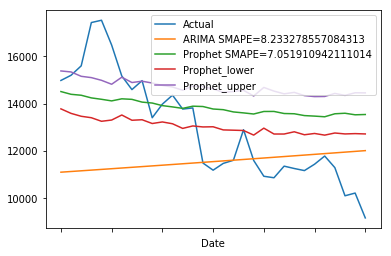

In [71]:
final_forecast[["Date", "Actual", "ARIMA SMAPE=8.233278557084313","Prophet SMAPE=7.051910942111014", "Prophet_lower","Prophet_upper"]].plot(x="Date", kind="line")

Above forecast can be optimized throught hyperparameter tuning which is time and resource consuming.The results are not optimized due to lack of time and resource.